In [1]:
# Setup
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../python/')
import ENDF6el as el
import flux_recoil_spec as frs
from statistics import median
from pyteomics import mass
from time import time

os.chdir('../data_files') #Set working directory to shorten paths
sys.path.append('EDW/')
import EDW

plt.style.use('../mplstyles/stylelib/standard.mplstyle')

In [2]:
#Import Data
f6TR_nu = pd.read_csv('SNOLAB/Fig6TR_neutrons.txt',encoding='utf-16',comment="#",header=None)
f7TR_nu = pd.read_csv('SNOLAB/Fig7TR_neutrons.txt',comment="#",header=None)
f6BR_nu = pd.read_csv('SNOLAB/Fig6BR_neutrons.txt',encoding='utf-16',comment="#",header=None)
f7BR_nu = pd.read_csv('SNOLAB/Fig7BR_neutrons.txt',comment="#",header=None)
f9BL = pd.read_csv('DAMIC/Fig9BL.txt',comment="#",header=None)
f9TL = pd.read_csv('DAMIC/Fig9TL.txt',comment="#",header=None)
f3_beta = pd.read_csv('EDW/Fig3_Betas.txt',encoding='utf-16',comment="#",header=None)

# Si Flux and Rate Generation
* CCDs are Si for the sake of flux

In [3]:
start = time()

#Flux specific to SNOLAB Si Detectors
Er = np.geomspace(100/1e6,1,100) #recoil energy
E,F,ff,ffspec = frs.SNOLAB_flux(Enmin=1e-3)

#Associated rate
try: #comment out if you need timing again
    #%store -r drde_Si drde_Ge
    #This one takes too long for testing, so saved it to file.
    drde_CaWO4_tot = np.loadtxt("drde_CaWO4.csv",delimiter=",")
    for name in ["drde_Si","drde_Ge","drde_CaWO4_tot"]:
        globals()[name] #force it to check for the variable
except KeyError: #The data wasn't saved, so we'll make it now.
    drde_Si = (mass.isotopic_composition_abundance({'Si[28]':1})*frs.dRdErfast(Er,E,F,N=1,Z=14,A=28)[0]
            + mass.isotopic_composition_abundance({'Si[29]':1})*frs.dRdErfast(Er,E,F,N=1,Z=14,A=29)[0]
            + mass.isotopic_composition_abundance({'Si[30]':1})*frs.dRdErfast(Er,E,F,N=1,Z=14,A=30)[0]
            )
    print(time()-start)
    drde_Ge = (mass.isotopic_composition_abundance({'Ge[70]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=70)[0]
            + mass.isotopic_composition_abundance({'Ge[72]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=72)[0]
            + mass.isotopic_composition_abundance({'Ge[73]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=73)[0]
            + mass.isotopic_composition_abundance({'Ge[74]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=74)[0]
            + mass.isotopic_composition_abundance({'Ge[76]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=76)[0]
            )
    #drde_CaWO4,_ = frs.dRdErCompound(Er,E,F,N=1,Comp='CaWO4') #use function ANV built
    %store drde_Si drde_Ge drde_CaWO4_tot
    print(time()-start)

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017017094, intercept=-12.883178144228603, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.014824519476613082, intercept_stderr=0.06273875262265761)
0.009998654133395216 0.01
../data_files/xn_data/si28_el.txt ../data_files/xn_data/n-014_Si_028.endf
../data_files/xn_data/si29_el.txt ../data_files/xn_data/n-014_Si_029.endf
../data_files/xn_data/si30_el.txt ../data_files/xn_data/n-014_Si_030.endf
1068.683688879013
../data_files/xn_data/ge70_el.txt ../data_files/xn_data/n-032_Ge_070.endf
../data_files/xn_data/ge72_el.txt ../data_files/xn_data/n-032_Ge_072.endf
../data_files/xn_data/ge73_el.txt ../data_files/xn_data/n-032_Ge_073.endf
../data_files/xn_data/ge74_el.txt ../data_files/xn_data/n-032_Ge_074.endf
../data_files/xn_data/ge76_el.txt ../data_files/xn_data/n-032_Ge_076.endf
Stored 'drde_Si' (ndarray)
Stored 'drde_Ge' (ndarray)
Stored 'drde_CaWO4_tot' (ndarra

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


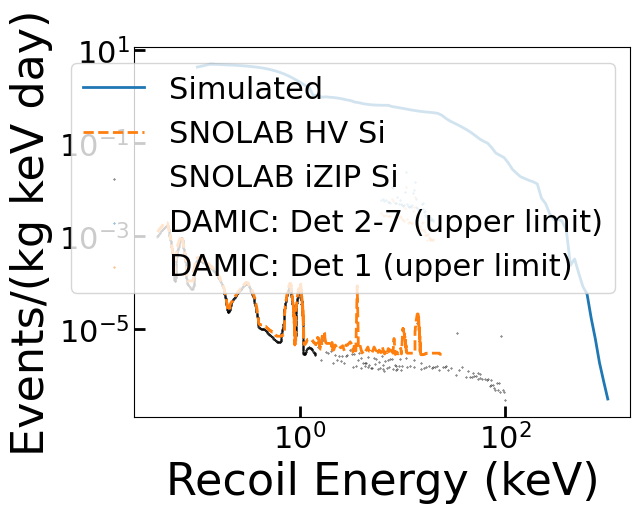

In [4]:
#Plot the data calculated above
plt.plot(Er*1000,drde_Si,label='Simulated')
plt.plot(f6TR_nu[0],f6TR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7TR_nu[0],f7TR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)
plt.scatter(f9TL[0],f9TL[1]/4/9.3/100,label='DAMIC: Det 2-7 (upper limit)',s=0.1)
plt.scatter(f9BL[0],f9BL[1]/4/1.6/100,label='DAMIC: Det 1 (upper limit)',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")

plt.legend()
#plt.save("../figures/flux_comparisons/
plt.show()

Compare shapes by re-scaling:

In [5]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0,myList[0]
    if pos == len(myList):
        return pos,myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return pos,after
    else:
        return pos,before

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


5.2789118728349384e-06


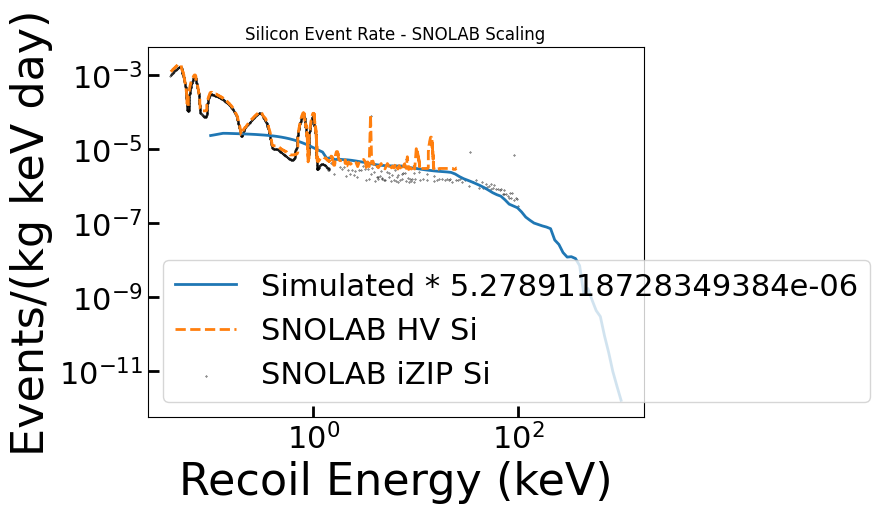

In [6]:
#finding values at 1keV

###Attempt at finding more robustly -- not working ###
#lorange = abs(f7TR_nu[0] - 2) < 0.5
#lo = median(f7TR_nu[1][lorange])/365
#closest = take_closest(list(f7TR_nu[1][lorange]),lo*365)
#print(closest)
#hi = drde_Si[
#    np.where(Er == take_closest(
#            Er,f7TR_nu[0][closest[0]])[1]
#    )
#]

###Simple by-eye version -- working ###
closest = take_closest(f6TR_nu[0],2)
lo = f6TR_nu[1][closest[0]]/365
hi = drde_Si[take_closest(Er*1000,2)[0]]

scale_SNOLABSi = lo/hi
print(scale_SNOLABSi)

#Plot the data calculated above
plt.plot(Er*1000,drde_Si*scale_SNOLABSi,label='Simulated * '+str(scale_SNOLABSi))
plt.plot(f6TR_nu[0],f6TR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7TR_nu[0],f7TR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Silicon Event Rate - SNOLAB Scaling")

plt.legend()
plt.show()

0.004716102802350275


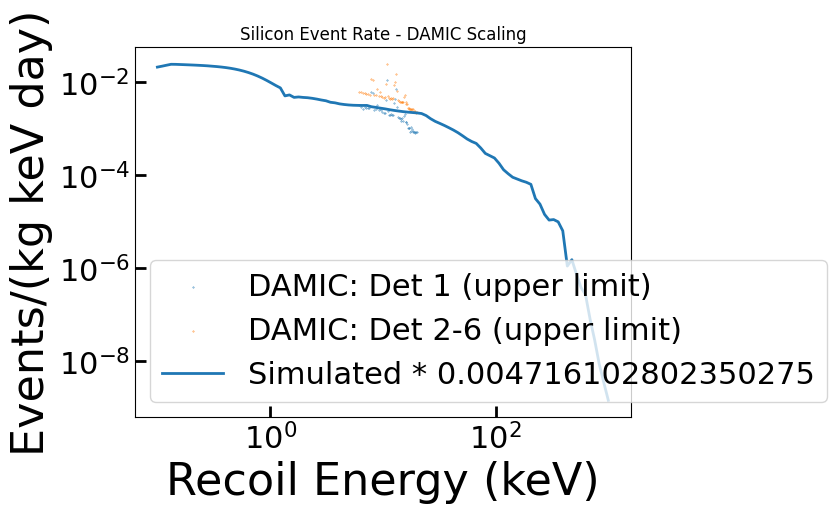

In [7]:
#finding values at 1keV

plt.scatter(f9BL[0],f9BL[1]/4/1.6/100,label='DAMIC: Det 1 (upper limit)',s=0.1)
plt.scatter(f9TL[0],f9TL[1]/4/9.3/100,label='DAMIC: Det 2-6 (upper limit)',s=0.1)

###Simple by-eye version -- working ###
closest = take_closest(f9BL[0],5)
lo = f9BL[1][closest[0]]/4/1.6/100
hi = drde_Si[take_closest(Er*1000,5)[0]] 

scale_DAMIC = lo/hi
print(scale_DAMIC)

#Plot the data calculated above
plt.plot(Er*1000,drde_Si*scale_DAMIC,label='Simulated * '+str(scale_DAMIC))

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Silicon Event Rate - DAMIC Scaling")

plt.legend()
plt.show()

Mention in paper: restrict to region 1-100keV

# Ge Flux and Rate Generation

See 1-.../pyteomics_test.ipynb > cell 22

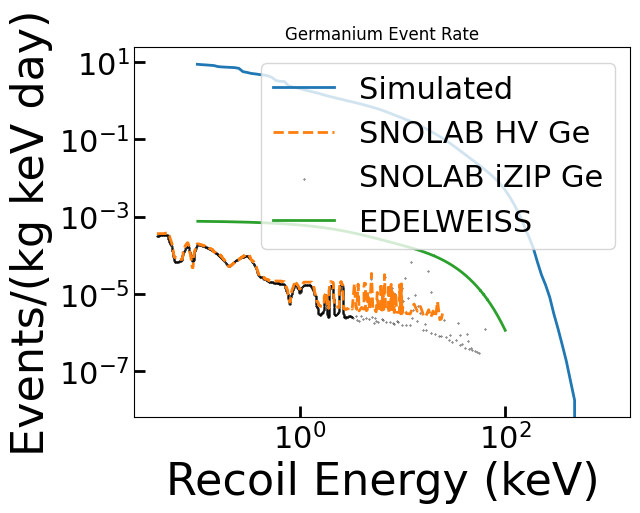

In [8]:
#Plot the data calculated above
#although these aren't entirely related
plt.plot(Er*1000,drde_Ge,label='Simulated')
plt.plot(f6BR_nu[0],f6BR_nu[1]/365,label='SNOLAB HV Ge',linestyle='--')
plt.scatter(f7BR_nu[0],f7BR_nu[1]/365,label='SNOLAB iZIP Ge',color='k',s=0.1)
plt.plot(f3_beta[0],EDW.neutrons(f3_beta[0]),label='EDELWEISS')

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Germanium Event Rate")

plt.legend()
plt.show()

5.102096706341595e-06


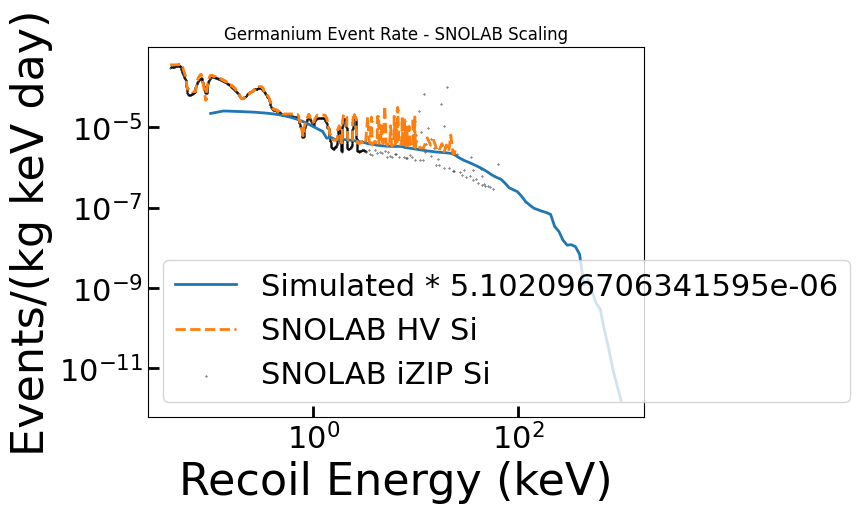

In [9]:
#finding values at 1keV

closest = take_closest(f6BR_nu[0],2)
lo = f7BR_nu[1][closest[0]]/365
hi = drde_Si[take_closest(Er*1000,2)[0]]
scale_SNOLABGe = lo/hi

#Plot the data calculated above
plt.plot(Er*1000,drde_Si*scale_SNOLABGe,label='Simulated * '+str(scale_SNOLABGe))
plt.plot(f6BR_nu[0],f6BR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7BR_nu[0],f7BR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Germanium Event Rate - SNOLAB Scaling")

print(scale_SNOLABGe)
plt.legend()
plt.show()

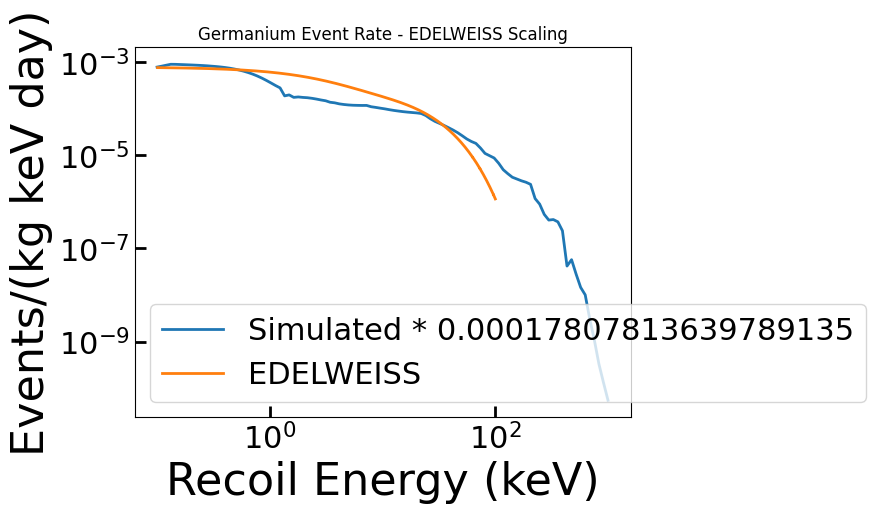

In [10]:
#finding values at 1keV

closest = take_closest(Er*1000,0)
lo = EDW.neutrons(closest[0])
hi = drde_Si[closest[0]]
scale_EDW = lo/hi

#Plot the data calculated above
plt.plot(Er*1000,drde_Si*scale_EDW,label='Simulated * '+str(scale_EDW))
plt.plot(f3_beta[0],EDW.neutrons(f3_beta[0]),label='EDELWEISS')

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Germanium Event Rate - EDELWEISS Scaling")

plt.legend()
plt.show()

# CaWO4

CRESST's recoils are CaWO4 so I need to create a plot for that as well.

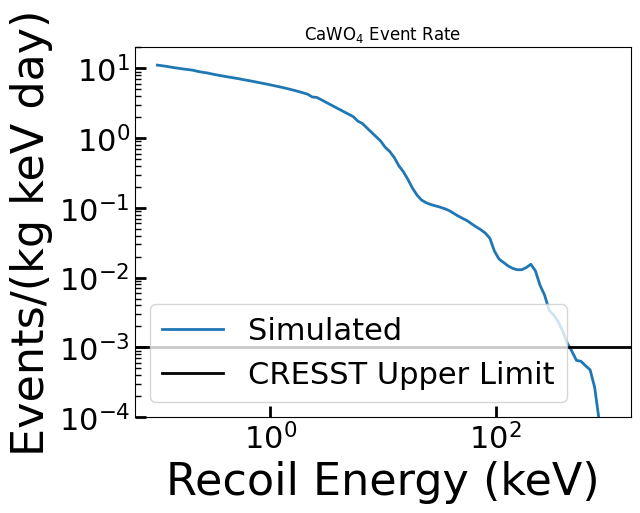

In [11]:
plt.plot(Er*1000,drde_CaWO4_tot,label='Simulated')
plt.axhline(1e-3,label='CRESST Upper Limit',color='k')

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.ylim(1e-4,2e1)

plt.title(r'CaWO$_4$ Event Rate')
plt.legend()
plt.show()

0.00017807813639789135


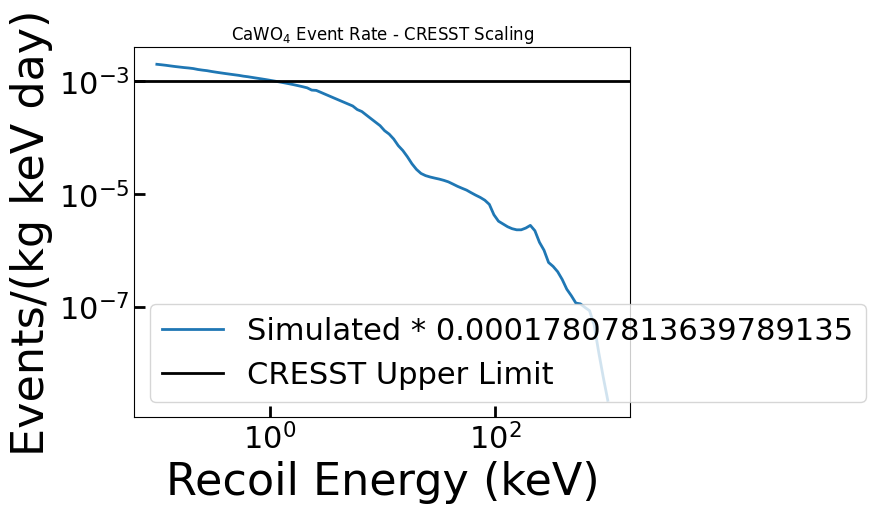

In [12]:
closest=take_closest(Er*1000,10)
lo = 1e-3
scale_CRESST = lo/drde_CaWO4_tot[closest[0]]

plt.plot(Er*1000,scale_EDW*drde_CaWO4_tot,label='Simulated * '+str(scale_EDW))
plt.axhline(1e-3,label='CRESST Upper Limit',color='k')

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
#plt.ylim(1e-4,2e1)

print(scale_EDW)
plt.title(r'CaWO$_4$ Event Rate - CRESST Scaling')
plt.legend()
plt.show()

# Scaled Comparisons

Next: add in bands for uncertainties
what are our uncertainties? no clear rigorous values for some of these...

In [13]:
#Load the data flux calc -- this apparently takes a good chunk of time
start = time()
try: #comment out if you need to get timing again
    %store -r fluxbase 
    fluxbase
except NameError: #If it's not saved, THEN calculate
    fluxbase = frs.SNOLAB_flux()
    %store fluxbase
    print(time() - start)

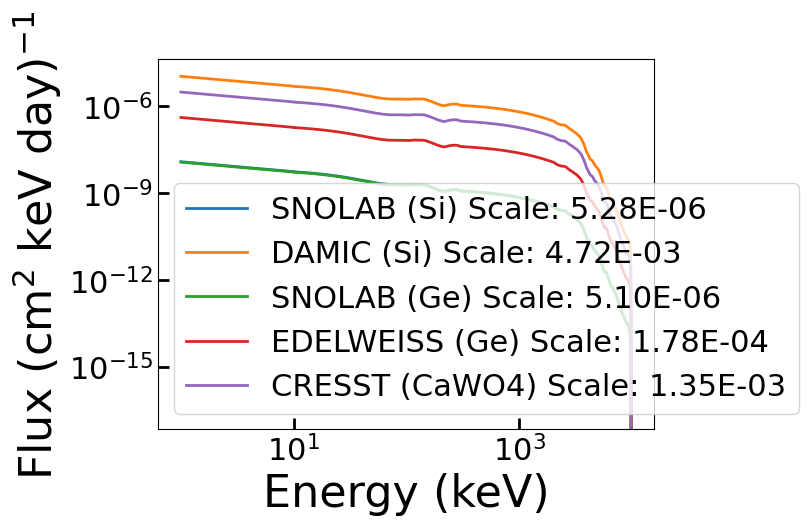

In [14]:
#Energy is in MeV on both scales; convert to keV
#then convert /s to /day
plt.plot(fluxbase[0]*1000,fluxbase[1]/1000*86400*scale_SNOLABSi,label='SNOLAB (Si) Scale: {:.2E}'.format(scale_SNOLABSi))
plt.plot(fluxbase[0]*1000,fluxbase[1]/1000*86400*scale_DAMIC,label='DAMIC (Si) Scale: {:.2E}'.format(scale_DAMIC))
plt.plot(fluxbase[0]*1000,fluxbase[1]/1000*86400*scale_SNOLABGe,label='SNOLAB (Ge) Scale: {:.2E}'.format(scale_SNOLABGe))
plt.plot(fluxbase[0]*1000,fluxbase[1]/1000*86400*scale_EDW,label='EDELWEISS (Ge) Scale: {:.2E}'.format(scale_EDW))
plt.plot(fluxbase[0]*1000,fluxbase[1]/1000*86400*scale_CRESST,label='CRESST (CaWO4) Scale: {:.2E}'.format(scale_CRESST))

plt.loglog()
#plt.xlim(min(fluxbase[0]*1000),5e3)

plt.xlabel('Energy (keV)')
plt.ylabel('Flux (cm$^2$ keV day)$^{-1}$')
plt.legend()
#plt.title('Scaled Flux') #Some journals don't want figure titles in the images, so leaving out

plt.savefig('../figures/scaled_rate_compare.png')
plt.show()

# Library Verification

This is a quick verification of the library dict to ensure it still matches the above calculations.

In [15]:
import ProjectFunctions as pf
for scale in ['SNOLABSi', 'SNOLABGe', 'DAMIC', 'EDW', 'CRESST']:
    if globals()['scale_'+scale] != pf.flux_scales[scale]:
        raise ValueError("Calculated value of scale_"+scale," and flux_scales['"+scale+"'] do not match!")

# Scaled Flux

Below is the calculated *flux* for SNOLAB, multiplied by the scales found above.

In [16]:
from scipy import signal
import scipy.stats as ss

fast_flux_df = pd.read_pickle('FDF.txt')

ff = np.asarray(fast_flux_df['E'])
ffspec = np.asarray(fast_flux_df['spec'])

#Need to split the array because we want to do different smoothing funcs
cutoff=0.3
ffle = ff[ff<=cutoff]; fflespec = ffspec[ff<=cutoff]
ffhe = ff[ff>cutoff]; ffhespec = ffspec[ff>cutoff]
#etot = np.concatenate((ffle,ffhe)) #I think I can just keep using ff here?

#Now apply smoothing
fflespec_smooth = signal.savgol_filter(fflespec,75,3)
ffhespec_smooth = signal.savgol_filter(ffhespec,2001,3)
etotspec = np.zeros((np.size(ff),),dtype=np.float64)
etotspec[ff<=cutoff] = fflespec_smooth
etotspec[ff>cutoff] = ffhespec_smooth

#Extrapolation
EE = np.geomspace(1e-3,2e-2,int(1e4))
E_thresh = 2e-2 # upper bound of linear region
E_therm = 0.15e-6 # near boundary of where thermal distribution has peak
fast_lin_df = ffle[ffle < E_thresh]
fast_lin_df_spec = fflespec_smooth[ffle< E_thresh]
fitted_line = ss.linregress(np.log(fast_lin_df), np.log(fast_lin_df_spec))
extrapolated = np.exp(fitted_line.intercept + fitted_line.slope*np.log(EE))*(EE > E_therm)

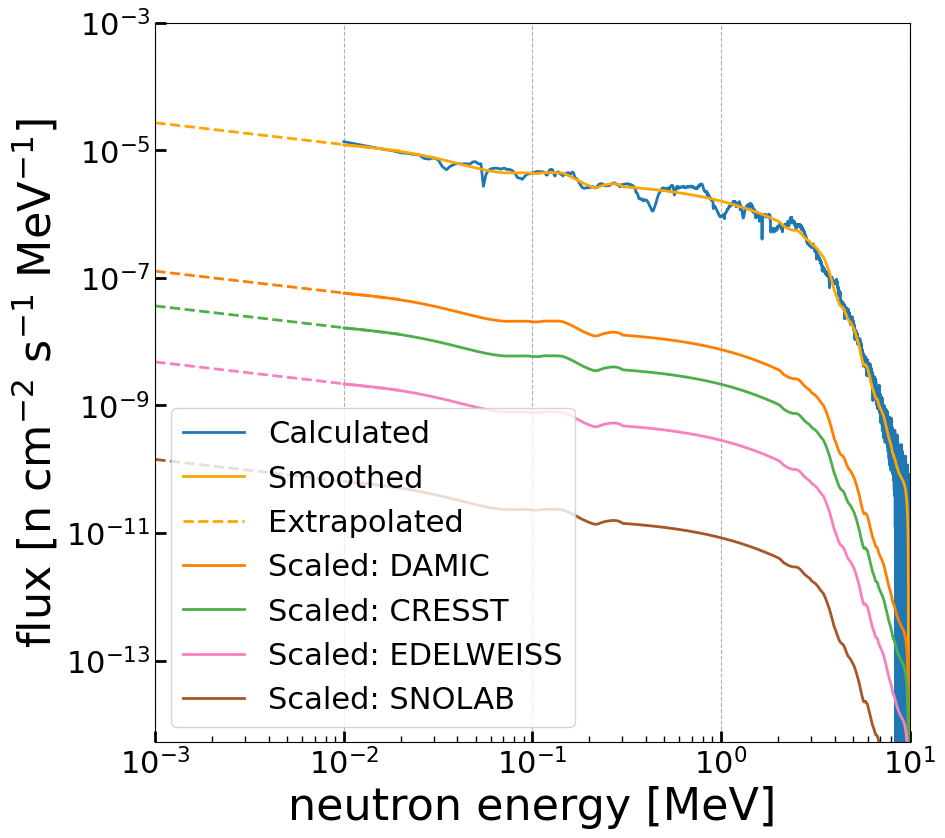

In [17]:
fig = plt.figure(figsize=(9,8))

plt.plot(ff,ffspec,label='Calculated')
plt.plot(ff,etotspec,label='Smoothed',color='orange')
plt.plot(EE,extrapolated,label='Extrapolated',linestyle='--',color='orange')

CB_color_cycle = ['#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
for i,x in enumerate([[scale_DAMIC,'DAMIC'],[scale_CRESST,'CRESST'],
                      [scale_EDW,'EDELWEISS'],[scale_SNOLABSi,'SNOLAB']
                      ]):
    plt.plot(ff,x[0]*etotspec,label='Scaled: '+x[1],color=CB_color_cycle[i])
    plt.plot(EE,x[0]*extrapolated,linestyle='--',color=CB_color_cycle[i])

#Didn't end up being visibly distinct
"""
plt.plot(ff,scale_SNOLABGe*ffspec,label='Calculated (Ge)',linewidth=1,color='orange')
plt.plot(ff,scale_SNOLABGe*etotspec,label='Smoothed (Ge)',linestyle='-.',color='red')
plt.plot(EE,scale_SNOLABGe*extrapolated,label='Extrapolated (Ge)',linestyle='--',color='red')
"""

plt.loglog()
plt.xlim(1e-3,10); plt.ylim(scale_SNOLABSi*1e-9,1e-3)
plt.tight_layout()
plt.legend(loc='lower left',prop={'size':22})
plt.grid(axis='y', which='minor',linestyle='--')
plt.grid(axis='x', which='major',linestyle='--')

plt.xlabel(r'neutron energy [MeV]')
plt.ylabel('flux [n cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')

plt.savefig('../figures/flux_scaled.png')
plt.show()